## Plot importances

Plot the importances of the features used in classification

### Files Needed:
1. Positions features as a csv

### Instructions:
Run cells in order

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
import sys

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier

# CV Splitting
import random as random
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.cross_validation import KFold
from sklearn.preprocessing import scale

# Evaluation
from sklearn.metrics import roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest

# Plotting
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Downsamplers imports - prototype selection - controlled
from imblearn.under_sampling import RandomUnderSampler

#Import utils functions
from utils import create_groups, test_model_iterative_fixed
curr_dir = !pwd
sys.path.append(curr_dir[0]+"/utils")
from neg_pos_funcs import create_negatives_datasets, create_positives_datasets
from CV_funcs import calc_CV_idx_iterative

from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

/home/anat/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Reading the input dataset

In [2]:
curr_dir = !pwd
input_path = curr_dir[0]+"/../../10.Prediction/domains_similarity/filtered_features_table/"
filename = "windowed_positions_features_mediode_filter_05.11.18.csv"
bind_scores_num = 10

features_all = pd.read_csv(input_path+filename, sep='\t', index_col=0)
ligands = ["dna", "dnabase", "dnabackbone", "rna", "rnabase", "rnabackbone", "peptide", "ion", "metabolite"]
#Features columns names, without the labels (the binding scores)
features_cols = features_all.columns.tolist()
#removing binding scores and domain name
for ligand in ligands:
    score_str = ligand+"_binding_score"
    features_cols.remove(score_str)
features_cols.remove("max_binding_score")
features_cols.remove("domain_name")

classifiers = {}
classifiers["Logistic"] = LogisticRegression(C=0.001, random_state=0)
classifiers["RF"] = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)
classifiers["KNN"] = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
classifiers["SVM"] = SVC(kernel='rbf', probability=True, random_state=0)
classifiers["ADA"] = AdaBoostClassifier(n_estimators=1000, random_state=0)
classifiers["XGB"] = XGBClassifier(n_estimators=1000, n_jobs=-1, random_state=0, max_depth=6, min_child_weight=0.05, colsample_bytree=0.5)

ABSOLUTE_NEGATIVES = False
FILTER_DOMAIN = False
FILTER_MAX_SCORE_ZERO = False

### Datasets of negative examples

In [3]:
ligands_negatives_df = create_negatives_datasets(FILTER_DOMAIN, ABSOLUTE_NEGATIVES, FILTER_MAX_SCORE_ZERO, features_all, features_cols)

dna non-binding #:38095
dnabase non-binding #:38577
dnabackbone non-binding #:38203
rna non-binding #:38047
rnabase non-binding #:38407
rnabackbone non-binding #:38223
peptide non-binding #:35437
ion non-binding #:34488
metabolite non-binding #:33971
all_ligands non-binding #:27191


### Datasets of positive examples by ligand

In [4]:
bind_th = 0.1
ligands_features_df = create_positives_datasets(bind_th, features_all, features_cols)

dna #: 501
dnabase #: 193
dnabackbone #: 408
rna #: 433
rnabase #: 224
rnabackbone #: 308
peptide #: 1496
ion #: 1093
metabolite #: 1525


### Plot top 10 features ranked by XGB

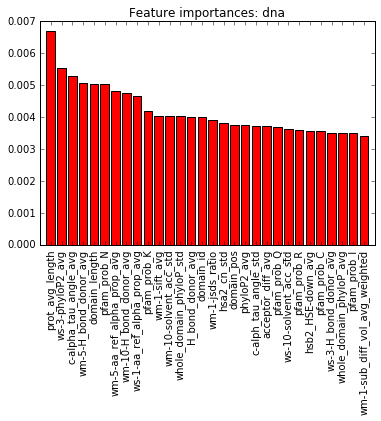

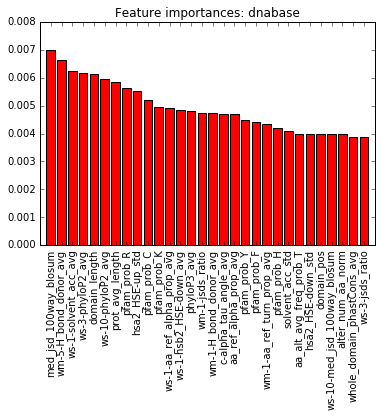

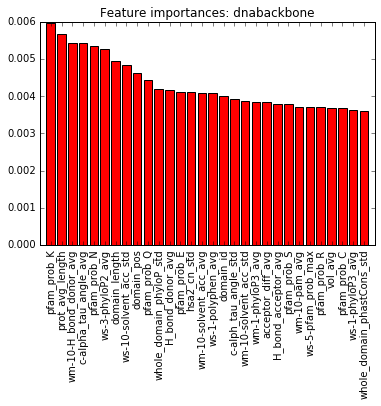

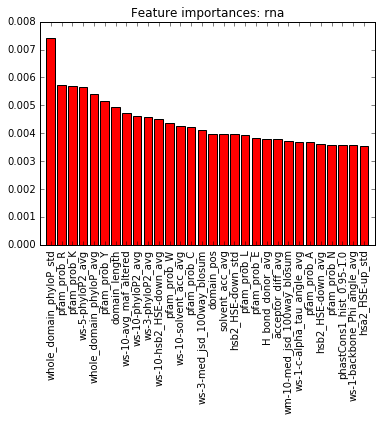

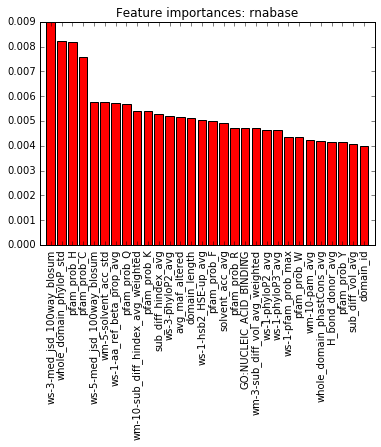

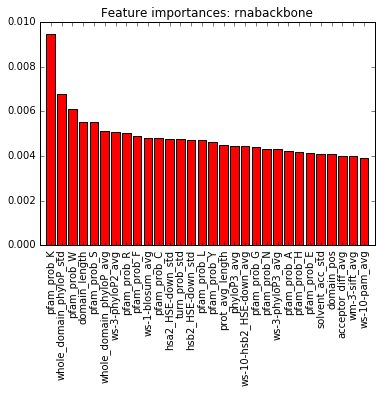

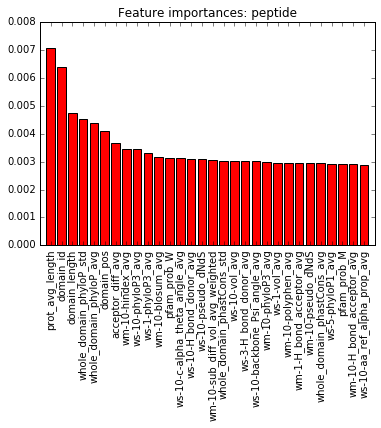

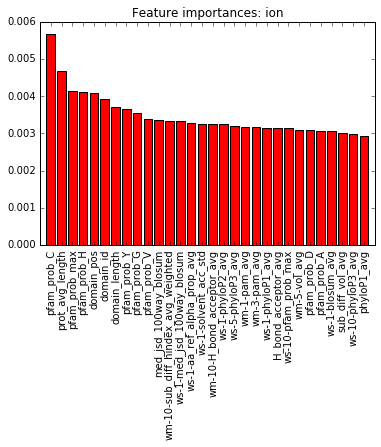

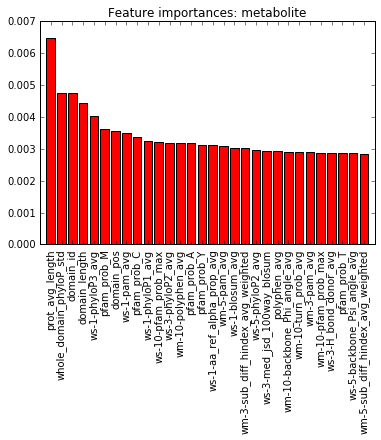

CPU times: user 2h 41min 38s, sys: 22.8 s, total: 2h 42min 1s
Wall time: 23min 25s


In [5]:
%%time
## Negatives from all domains
features_list = np.array([c.encode('ascii','ignore') for c in ligands_features_df['dna'].columns])
# Build a forest and compute the feature importances
forest = XGBClassifier(n_estimators=1000, n_jobs=-1, random_state=0, max_depth=6, min_child_weight=0.05, colsample_bytree=0.5)
#forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

TOP_N = 30
for ligand in ligands:
    # Sample positives and negatives
    X = pd.concat([ligands_features_df[ligand], ligands_negatives_df[ligand]])
    y = [1] * ligands_features_df[ligand].shape[0]
    y.extend([0] * ligands_negatives_df[ligand].shape[0])
    y = np.array(y)
    
    
    forest.fit(X, y)
    importances = forest.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in forest.estimators_],
    #             axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances: "+ligand)
    plt.bar(range(TOP_N), importances[indices][0:TOP_N],
           color="r", align="center")
    plt.xticks(range(TOP_N), features_list[indices][0:TOP_N], rotation=90)
    plt.xlim([-1, TOP_N])
    plt.show()

### Plot top 10 features ranked by RF

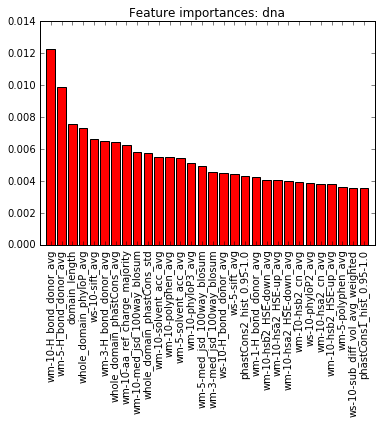

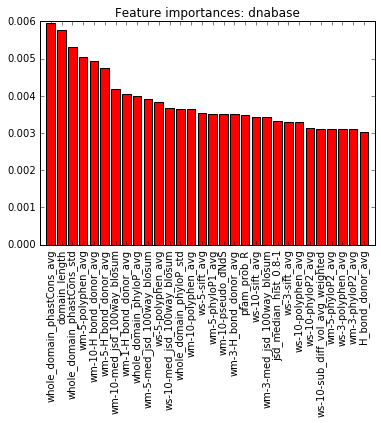

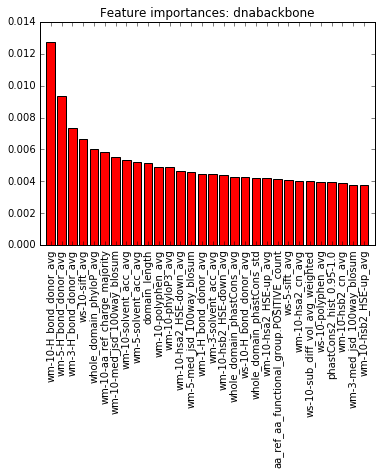

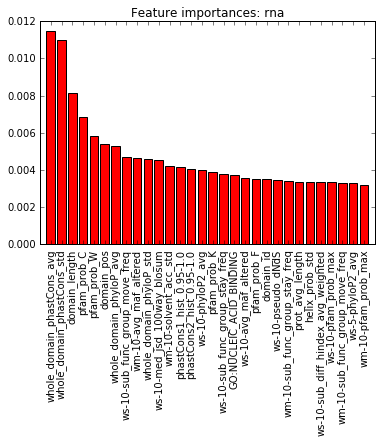

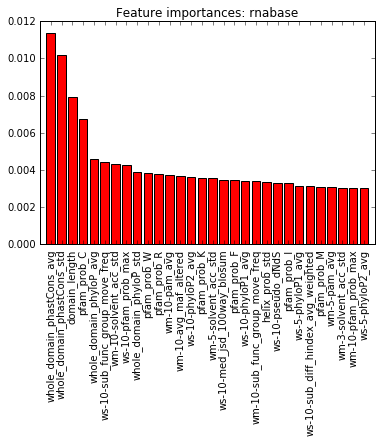

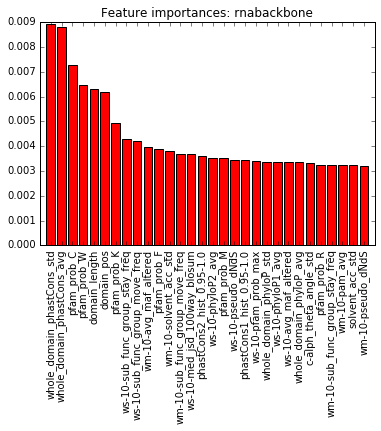

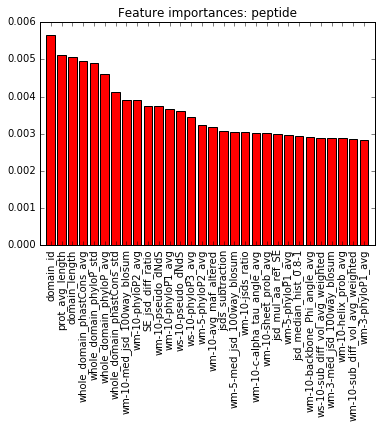

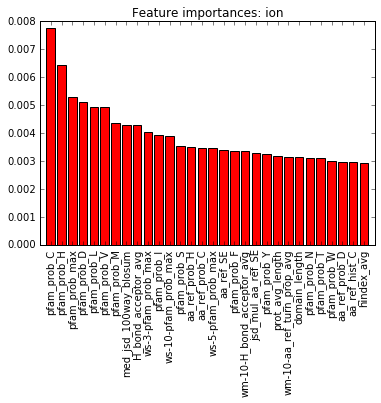

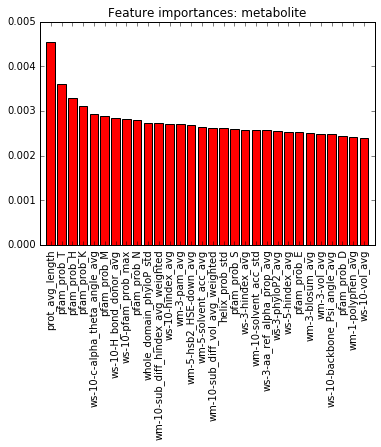

In [6]:
features_list = np.array([c.encode('ascii','ignore') for c in ligands_features_df['dna'].columns])
# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)
#forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

TOP_N = 30
for ligand in ligands:
    # Sample positives and negatives
    X = pd.concat([ligands_features_df[ligand], ligands_negatives_df[ligand]])
    y = [1] * ligands_features_df[ligand].shape[0]
    y.extend([0] * ligands_negatives_df[ligand].shape[0])
    y = np.array(y)
    
    forest.fit(X, y)
    importances = forest.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in forest.estimators_],
    #             axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances: "+ligand)
    plt.bar(range(TOP_N), importances[indices][0:TOP_N],
           color="r", align="center")
    plt.xticks(range(TOP_N), features_list[indices][0:TOP_N], rotation=90)
    plt.xlim([-1, TOP_N])
    plt.show()

### Test features and create ranking DEPRECATED

In [8]:
# List of features
features_list = np.array([c.encode('ascii','ignore') for c in ligands_features_df['dna'].columns])
# Rankings by ligand/test
ranking = defaultdict(list)

for ligand in ligands:
    # Down-sample
    X = pd.concat([ligands_features_df[ligand], ligands_negatives_df[ligand]])
    y = [1] * ligands_features_df[ligand].shape[0]
    y.extend([0] * ligands_negatives_df[ligand].shape[0])
    y = np.array(y)
    X_sampled, y_sampled = RandomUnderSampler(random_state=0).fit_sample(X, y)
    
    # Feature selection models
    var_model = VarianceThreshold(threshold=(.3)).fit(X_sampled,y_sampled)
    kbest_model = SelectKBest(k=200).fit(X_sampled,y_sampled)
    trees_model = ExtraTreesClassifier().fit(X_sampled,y_sampled)

    # Extract feature scores and remove NaNs
    # Variances for var; ANOVA f-value for kbest; Relative importances for trees
    var = np.asarray(var_model.variances_)
    var[np.isnan(var)] = -1
    kbest = np.asarray(kbest_model.scores_)
    kbest[np.isnan(kbest)] = -1
    trees = np.asarray(trees_model.feature_importances_)
    trees[np.isnan(trees)] = -1

    # Create ranking
    ranking[ligand+"_var"] = features_list[np.argsort(var)][::-1]
    ranking[ligand+"_kbest"] = features_list[np.argsort(kbest)][::-1]
    ranking[ligand+"_trees"] = features_list[np.argsort(trees)][::-1]

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning:

Features [346 347] are constant.

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning:

invalid value encountered in divide

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning:

Features [  9 346 347] are constant.

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning:

Features [186 207 346 347 348 349] are constant.

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning:

Features [  9 186 207 346 347 348 349] are constant.



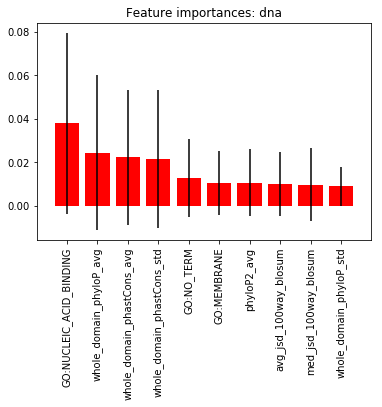

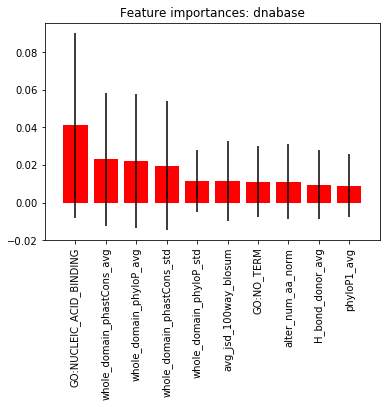

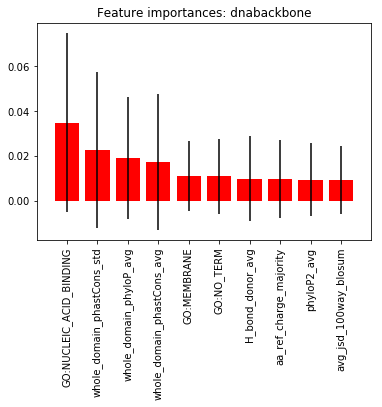

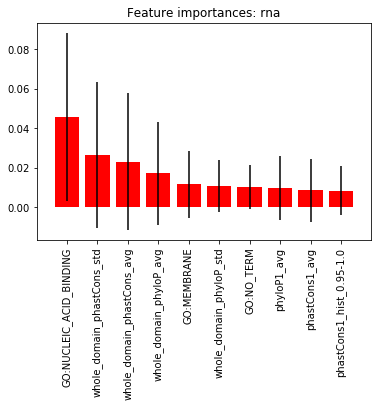

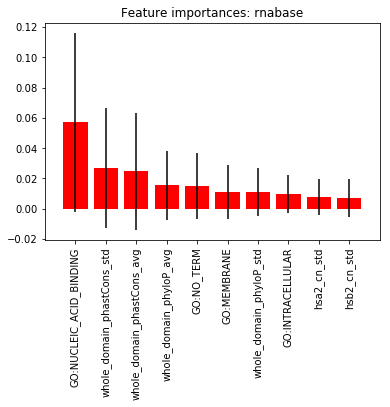

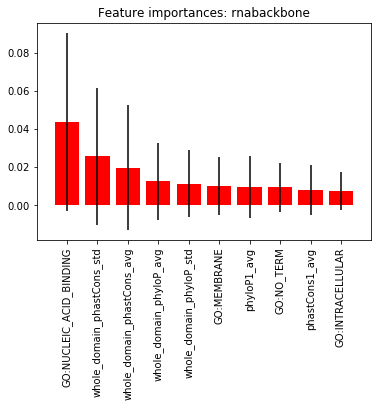

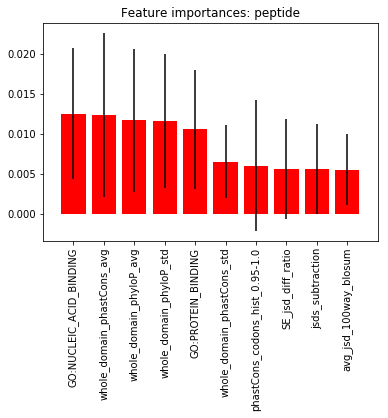

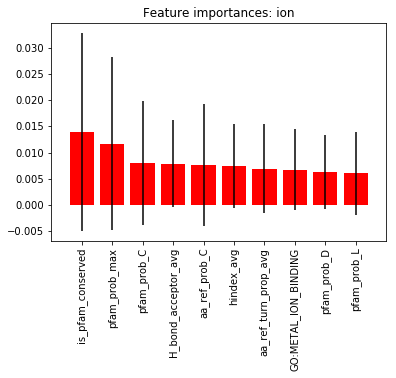

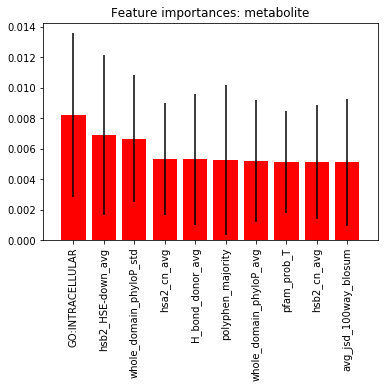

In [11]:
## Ligand negatives only from domains with at least one ligand binding position

features_list = np.array([c.encode('ascii','ignore') for c in ligands_features_df['dna'].columns])
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
for ligand in ligands:
    # Sample positives and negatives
    X = pd.concat([ligands_features_df[ligand], ligands_negatives_df[ligand]])
    y = [1] * ligands_features_df[ligand].shape[0]
    y.extend([0] * ligands_negatives_df[ligand].shape[0])
    y = np.array(y)
    X_sampled, y_sampled = RandomUnderSampler(random_state=0).fit_sample(X, y)
    
    forest.fit(X_sampled, y_sampled)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances: "+ligand)
    plt.bar(range(10), importances[indices][0:10],
           color="r", yerr=std[indices][0:10], align="center")
    plt.xticks(range(10), features_list[indices][0:10], rotation=90)
    plt.xlim([-1, 10])
    plt.show()